In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import sys
import os
import re
from collections import Counter
from pathlib import Path
import dotenv
import numpy as np
import pandas as pd
import pyopenms
from matplotlib import pyplot as plt
import seaborn as sns
import pyopenms

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
REPO_DIR = Path(os.getcwd()).parent.parent
dotenv.load_dotenv(REPO_DIR/'.env')
DATA_DIR = Path(os.environ.get('DATA_DIR'))

In [88]:
custom_libs = [
    REPO_DIR/'src/lib/py'
]

for lib in custom_libs:
    lib = str(lib.resolve())
    if lib not in sys.path:
        sys.path.append(lib)

from analysis_helpers import (
    FragPipeResults,
    prepare_acc_2_tier_mapping,
    compare_mixture_to_individual_protein_groups,
    summarize_mixture_comparison,
    plot_tier_status_grid,
    plot_status_boxplots,
    compare_mixture_to_individual_peptides,
    plot_status_counts_barplot
)

In [6]:
acc_2_tier = prepare_acc_2_tier_mapping(database_path = DATA_DIR/'data/van_puyvelde-2022/Protein/DIA/Database/merged_database-ecoli_yeast_human-20260109.fasta')

In [7]:
fragpipe_dir = DATA_DIR/'data/van_puyvelde-2022/Protein/DIA/fragpipe/v02'
fragpipe_results = {
    'ecoli_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Ecoli_01'),
    'yeast_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Yeast_01'),
    'human_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Human_01'),
    'condition_a_alpha_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01/'),
    'condition_b_alpha_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Condition_B_Sample_Alpha_01')
}

In [8]:
mixture_samples = [
    'condition_a_alpha_01',
    'condition_b_alpha_01'
]
individual_samples = {
    "ecoli_01",
    "yeast_01",
    "human_01",
}
id_protein_groups = {
    k: v.split_fdr.tidy_protein_groups(acc_2_tier)
        if k in mixture_samples
        else v.global_fdr.tidy_protein_groups(acc_2_tier)
        for k,v in fragpipe_results.items()
}

In [9]:
id_protein_groups['condition_a_alpha_01']

,Protein Group,Probability,Qvalue,Tier
0,AAC73119,1.0,0.011494,Ecoli
1,AAC73125,1.0,0.011494,Ecoli
2,AAC73229,1.0,0.011494,Ecoli
3,AAC73281,1.0,0.011494,Ecoli
4,AAC73706,1.0,0.011494,Ecoli
...,...,...,...,...
15680,ENSP00000642641.1,0.0,0.022542,Human
15681,ENSP00000642709.1,0.0,0.022542,Human
15682,ENSP00000642716.1,0.0,0.022542,Human
15683,ENSP00000642722.1,0.0,0.022542,Human


In [10]:
teir_to_individual_sample = {
    "Ecoli": "ecoli_01",
    "Yeast": "yeast_01",
    "Human": "human_01",
}
df_compare = compare_mixture_to_individual_protein_groups(
    mixture_tables = {x: id_protein_groups[x] for x in mixture_samples},
    individual_tables = {x: id_protein_groups[x] for x in individual_samples},
    tier_to_individual_sample = teir_to_individual_sample
)

In [11]:
df_compare

,Mixture Sample,Tier,Protein Group,Individual Sample,Mixture Present,Individual Present,Status
0,condition_a_alpha_01,Ecoli,AAC73113,ecoli_01,False,True,individual_only
1,condition_a_alpha_01,Ecoli,AAC73115,ecoli_01,False,True,individual_only
2,condition_a_alpha_01,Ecoli,AAC73117,ecoli_01,False,True,individual_only
3,condition_a_alpha_01,Ecoli,AAC73119,ecoli_01,True,True,both
4,condition_a_alpha_01,Ecoli,AAC73120,ecoli_01,False,True,individual_only
...,...,...,...,...,...,...,...
46821,condition_b_alpha_01,Yeast,ONH81060,yeast_01,False,True,individual_only
46822,condition_b_alpha_01,Yeast,ONH81061,yeast_01,True,True,both
46823,condition_b_alpha_01,Yeast,ONH81062,yeast_01,False,True,individual_only
46824,condition_b_alpha_01,Yeast,ONH81063,yeast_01,True,True,both


In [13]:
df_sumamry = summarize_mixture_comparison(df_compare, mixture_samples)
df_sumamry

,Mixture Sample,Tier,Status,Protein Count
0,condition_a_alpha_01,Ecoli,both,121
1,condition_a_alpha_01,Ecoli,individual_only,1464
2,condition_a_alpha_01,Ecoli,mixture_only,7
3,condition_a_alpha_01,Human,both,12577
4,condition_a_alpha_01,Human,individual_only,4284
5,condition_a_alpha_01,Human,mixture_only,1884
6,condition_a_alpha_01,Yeast,both,1070
7,condition_a_alpha_01,Yeast,individual_only,1963
8,condition_a_alpha_01,Yeast,mixture_only,26
9,condition_b_alpha_01,Ecoli,both,344


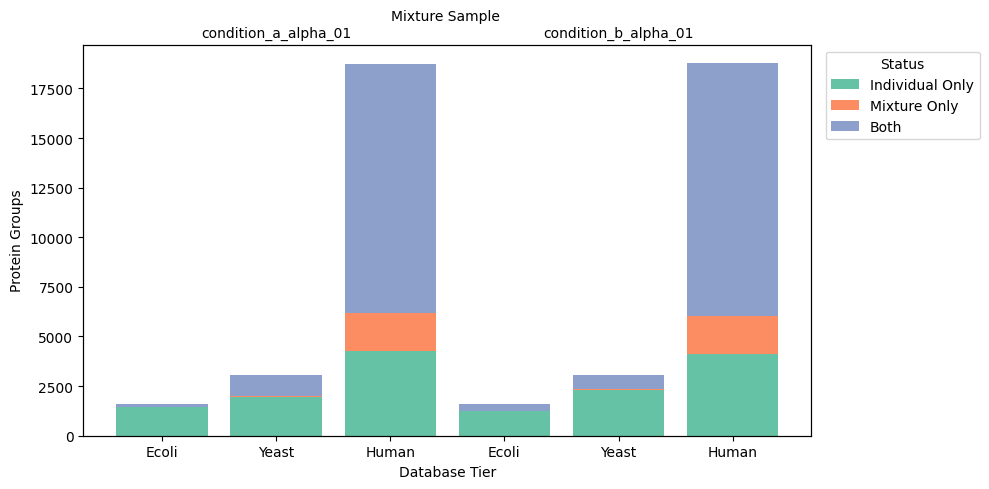

In [14]:
status_order = ['individual_only', 'mixture_only', 'both']
tier_order = ['Ecoli', 'Yeast', 'Human']
pivot = (
    df_sumamry
    .pivot_table(index=['Mixture Sample', 'Tier'], columns='Status', values='Protein Count', fill_value=0)
    .reindex(pd.MultiIndex.from_product([mixture_samples, tier_order], names=['Mixture Sample', 'Tier']), fill_value=0)
)
pivot = pivot.reindex(columns=status_order, fill_value=0)
positions = []
tier_labels = []
counts = {status: [] for status in status_order}
idx = 0
for sample in mixture_samples:
    for tier in tier_order:
        row = pivot.loc[(sample, tier)]
        tier_labels.append(tier)
        positions.append(idx)
        for status in status_order:
            counts[status].append(row[status])
        idx += 1
fig, ax = plt.subplots(figsize=(10, 5))
bottom = [0] * len(positions)
colors = sns.color_palette('Set2', len(status_order))
for color, status in zip(colors, status_order):
    ax.bar(positions, counts[status], bottom=bottom, label=status.replace('_', ' ').title(), color=color)
    bottom = [b + v for b, v in zip(bottom, counts[status])]
ax.set_xticks(positions)
ax.set_xticklabels(tier_labels)
ax.set_xlabel('Database Tier')
ax.set_ylabel('Protein Groups')
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
sample_centers = []
tiers_per_sample = len(tier_order)
for i in range(len(mixture_samples)):
    start = i * tiers_per_sample
    sample_centers.append(start + (tiers_per_sample - 1) / 2)
ax2.set_xticks(sample_centers)
ax2.set_xticklabels(mixture_samples)
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Mixture Sample ')
ax2.tick_params(axis='x', which='both', length=0)
ax.legend(title='Status', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()

In [15]:
diann_columns = [
    'Protein.Group',
    'PG.Quantity',
    'PG.Normalised',
    'PG.MaxLFQ'
]

def simplify_protein_group(df):
    return df.assign(**{'Protein.Group': df['Protein.Group'].str.split().str[0]})

def collapsed_diann_summary(sample):
    return (
        simplify_protein_group(
            fragpipe_results[sample]
            .diann_report[diann_columns]
        )
        .groupby('Protein.Group', group_keys=False)
        .first()
        .reset_index()
        .rename(columns={'Protein.Group': 'Protein Group'})
    )

df_with_diann = pd.concat([
    df_compare[df_compare['Mixture Sample'] == s]
        .merge(
            right=collapsed_diann_summary(s),
            on=['Protein Group'],
            how='left'
        )
    for s in mixture_samples
])
df_with_diann = pd.concat([
    df_with_diann[df_with_diann['Tier'] == t]
        .merge(
            right=collapsed_diann_summary(s),
            on=['Protein Group'],
            how='left'
        )
    for t,s in teir_to_individual_sample.items()
])
df_with_diann

,Mixture Sample,Tier,Protein Group,Individual Sample,Mixture Present,Individual Present,Status,PG.Quantity_x,PG.Normalised_x,PG.MaxLFQ_x,PG.Quantity_y,PG.Normalised_y,PG.MaxLFQ_y
0,condition_a_alpha_01,Ecoli,AAC73113,ecoli_01,False,True,individual_only,NaN,NaN,NaN,4895.665527,4895.665527,4895.664062
1,condition_a_alpha_01,Ecoli,AAC73115,ecoli_01,False,True,individual_only,NaN,NaN,NaN,6867.598633,6867.598633,6867.599609
2,condition_a_alpha_01,Ecoli,AAC73117,ecoli_01,False,True,individual_only,NaN,NaN,NaN,3017.207520,3017.207520,3017.207031
3,condition_a_alpha_01,Ecoli,AAC73119,ecoli_01,True,True,both,4089.62,4089.62,4089.61,84341.500000,84341.500000,84341.507810
4,condition_a_alpha_01,Ecoli,AAC73120,ecoli_01,False,True,individual_only,NaN,NaN,NaN,2619.326416,2619.326416,2619.326904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37510,condition_b_alpha_01,Human,ENSP00000642713.1,human_01,False,True,individual_only,NaN,NaN,NaN,NaN,NaN,NaN
37511,condition_b_alpha_01,Human,ENSP00000642716.1,human_01,True,False,mixture_only,NaN,NaN,NaN,NaN,NaN,NaN
37512,condition_b_alpha_01,Human,ENSP00000642722.1,human_01,False,True,individual_only,NaN,NaN,NaN,NaN,NaN,NaN
37513,condition_b_alpha_01,Human,ENSP00000642725.1,human_01,False,True,individual_only,NaN,NaN,NaN,NaN,NaN,NaN


/home/chenghaozhu/project/project-DIAProteomicBenchmark/src/lib/py/analysis_helpers.py:317: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/chenghaozhu/project/project-DIAProteomicBenchmark/src/lib/py/analysis_helpers.py:342: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/chenghaozhu/project/project-DIAProteomicBenchmark/src/lib/py/analysis_helpers.py:421: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


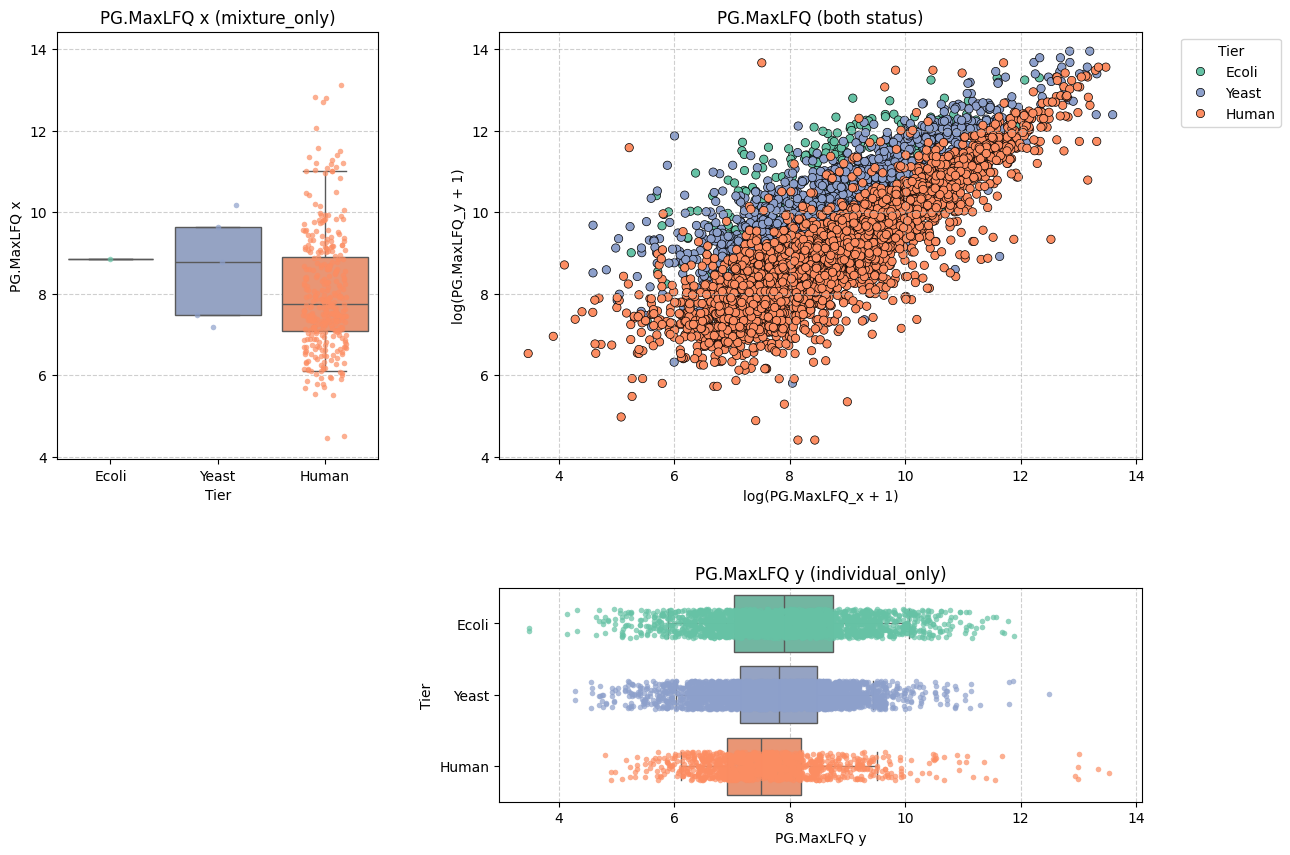

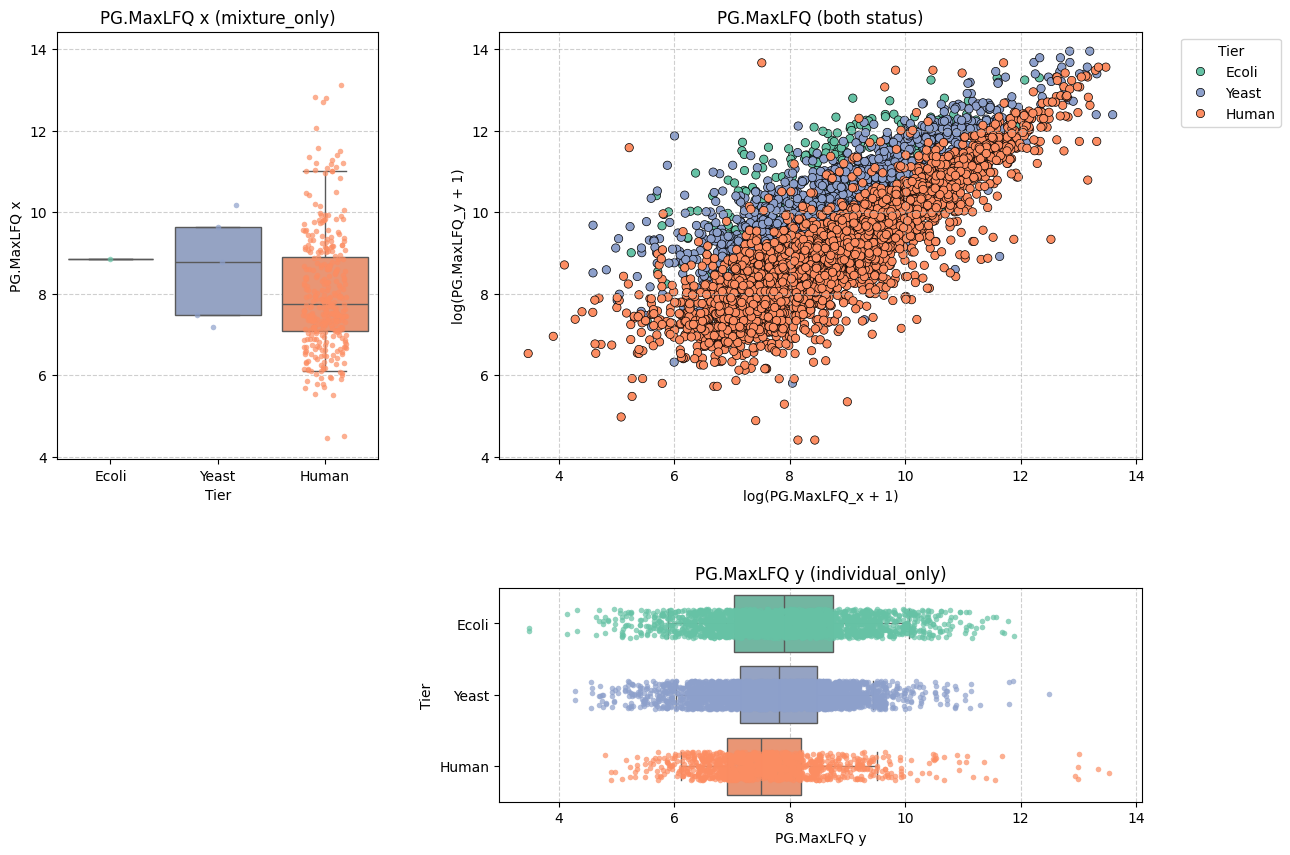

In [16]:
fig = plot_tier_status_grid(df_with_diann)
fig

/home/chenghaozhu/project/project-DIAProteomicBenchmark/src/lib/py/analysis_helpers.py:438: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/chenghaozhu/project/project-DIAProteomicBenchmark/src/lib/py/analysis_helpers.py:438: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/chenghaozhu/project/project-DIAProteomicBenchmark/src/lib/py/analysis_helpers.py:438: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/chenghaozhu/project/project-DIAProteomicBenchmark/src/lib/py/analysis_helpers.py:438: FutureWarning: 

Passing `palette` wit

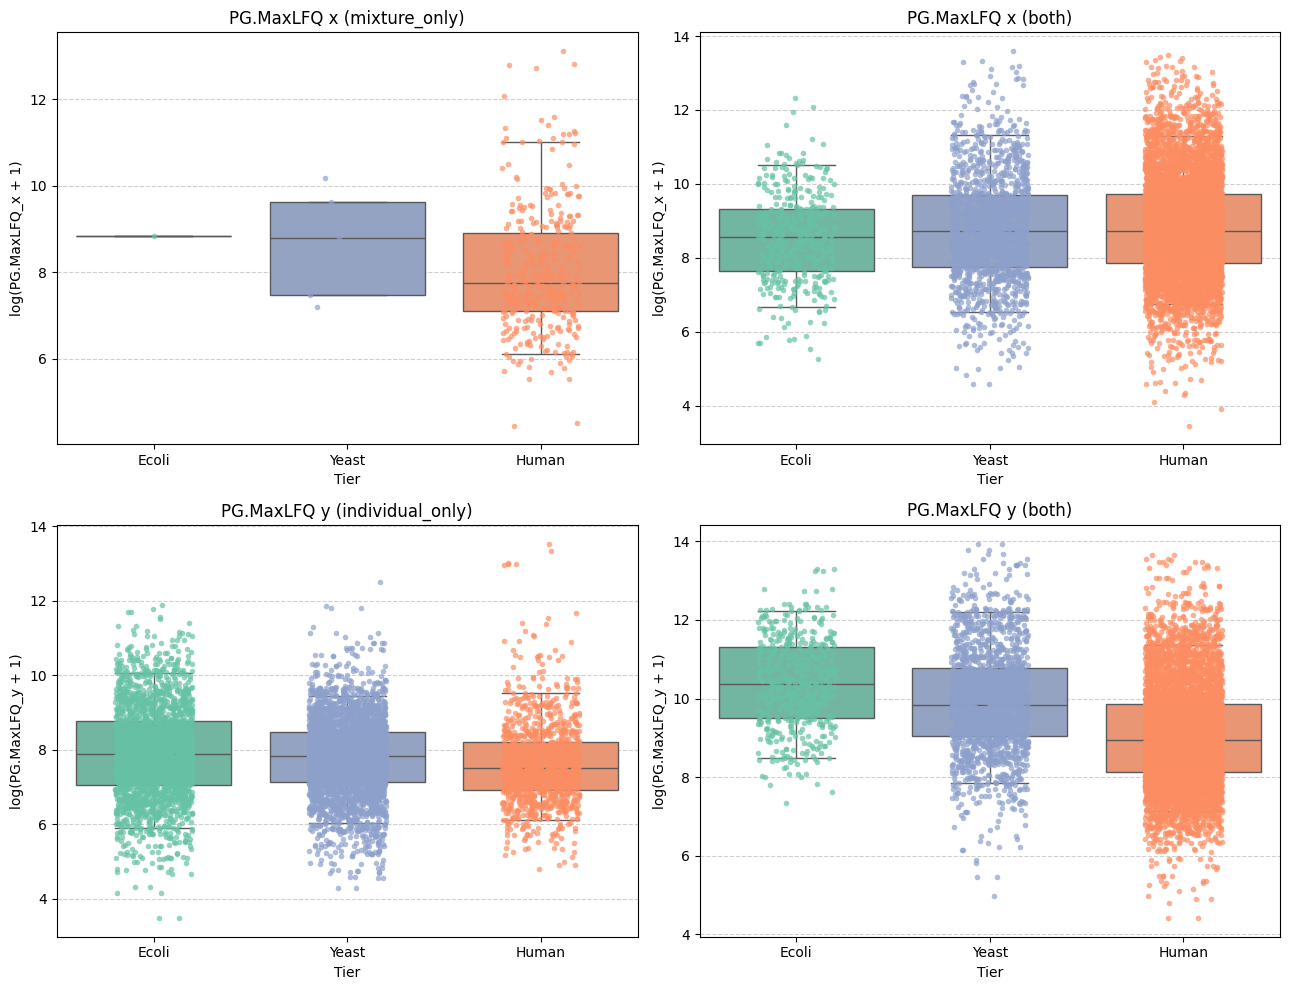

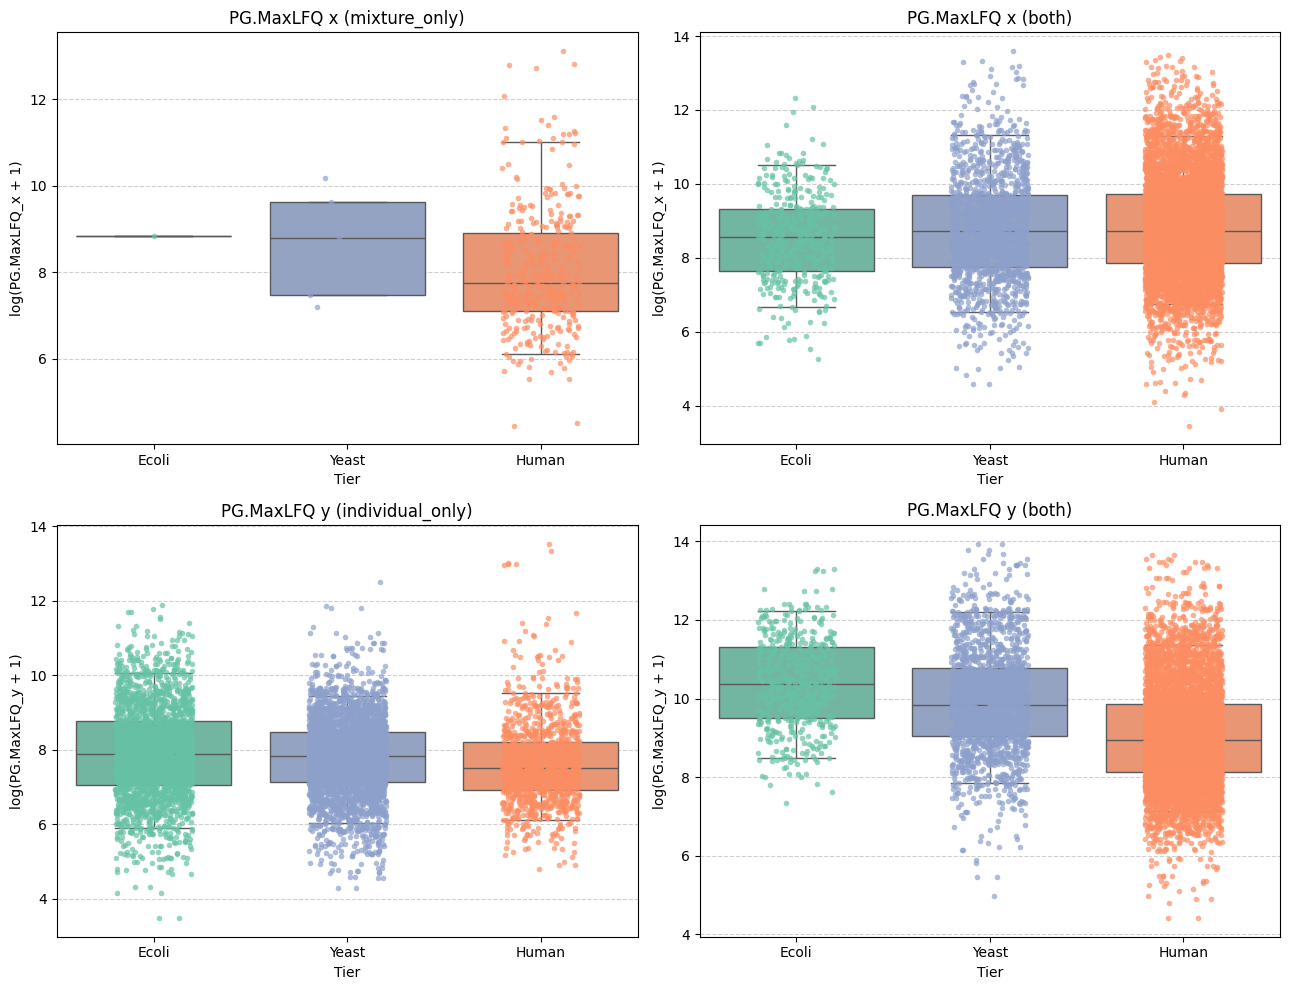

In [17]:
fig = plot_status_boxplots(df_with_diann)
fig

## Peptides

In [80]:
mixture_samples = [
    'condition_a_alpha_01',
    'condition_b_alpha_01'
]
individual_samples = {
    "ecoli_01",
    "yeast_01",
    "human_01",
}
id_peptides = {
    k: v.split_fdr.tidy_peptide_id()
        if k in mixture_samples
        else v.global_fdr.tidy_peptide_id()
        for k,v in fragpipe_results.items()
}

In [95]:
mixture_tables = {s:id_peptides[s] for s in mixture_samples}
individual_tables = {s:id_peptides[s] for s in individual_samples}
df_compare_peptides = compare_mixture_to_individual_peptides(
    mixture_tables = mixture_tables,
    individual_tables = individual_tables,
    tier_to_individual_sample = teir_to_individual_sample
)

In [96]:
df_compare_peptides

,Mixture Sample,Tier,Peptide,Modified Peptide,Unimod Peptide,Charge,Individual Sample,Mixture Present,Individual Present,Status
0,condition_a_alpha_01,Ecoli,FENITAAPADPILGLADLFR,.(Acetyl)FENITAAPADPILGLADLFR,.(UniMod:1)FENITAAPADPILGLADLFR,3,ecoli_01,False,True,individual_only
1,condition_a_alpha_01,Ecoli,MFENITAAPADPILGLADLFR,.(Acetyl)MFENITAAPADPILGLADLFR,.(UniMod:1)MFENITAAPADPILGLADLFR,3,ecoli_01,False,True,individual_only
2,condition_a_alpha_01,Ecoli,MIQEQTMLNVADNSGAR,.(Acetyl)MIQEQTMLNVADNSGAR,.(UniMod:1)MIQEQTMLNVADNSGAR,2,ecoli_01,False,True,individual_only
3,condition_a_alpha_01,Ecoli,MLQISHLYADYGGK,.(Acetyl)MLQISHLYADYGGK,.(UniMod:1)MLQISHLYADYGGK,2,ecoli_01,False,True,individual_only
4,condition_a_alpha_01,Ecoli,MSQPITRENFDEWMIPVYAPAPFIPVR,.(Acetyl)MSQPITRENFDEWM(Oxidation)IPVYAPAPFIPVR,.(UniMod:1)MSQPITRENFDEWM(UniMod:35)IPVYAPAPFIPVR,4,ecoli_01,False,True,individual_only
...,...,...,...,...,...,...,...,...,...,...
119213,condition_b_alpha_01,Yeast,YYSIYDLGNNAVGLAK,YYSIYDLGNNAVGLAK,YYSIYDLGNNAVGLAK,2,yeast_01,True,False,mixture_only
119214,condition_b_alpha_01,Yeast,YYTFNGPNYNENETIR,YYTFNGPNYNENETIR,YYTFNGPNYNENETIR,2,yeast_01,False,True,individual_only
119215,condition_b_alpha_01,Yeast,YYTITEVATR,YYTITEVATR,YYTITEVATR,2,yeast_01,False,True,individual_only
119216,condition_b_alpha_01,Yeast,YYWNLSK,YYWNLSK,YYWNLSK,2,yeast_01,False,True,individual_only


In [67]:
df_sumamry = summarize_mixture_comparison(df_compare_peptides, mixture_samples)
df_sumamry

,Mixture Sample,Tier,Status,Count
0,condition_a_alpha_01,Ecoli,both,273
1,condition_a_alpha_01,Ecoli,individual_only,9928
2,condition_a_alpha_01,Ecoli,mixture_only,22
3,condition_a_alpha_01,Human,both,15845
4,condition_a_alpha_01,Human,individual_only,9982
5,condition_a_alpha_01,Human,mixture_only,5191
6,condition_a_alpha_01,Yeast,both,4456
7,condition_a_alpha_01,Yeast,individual_only,14222
8,condition_a_alpha_01,Yeast,mixture_only,635
9,condition_b_alpha_01,Ecoli,both,930


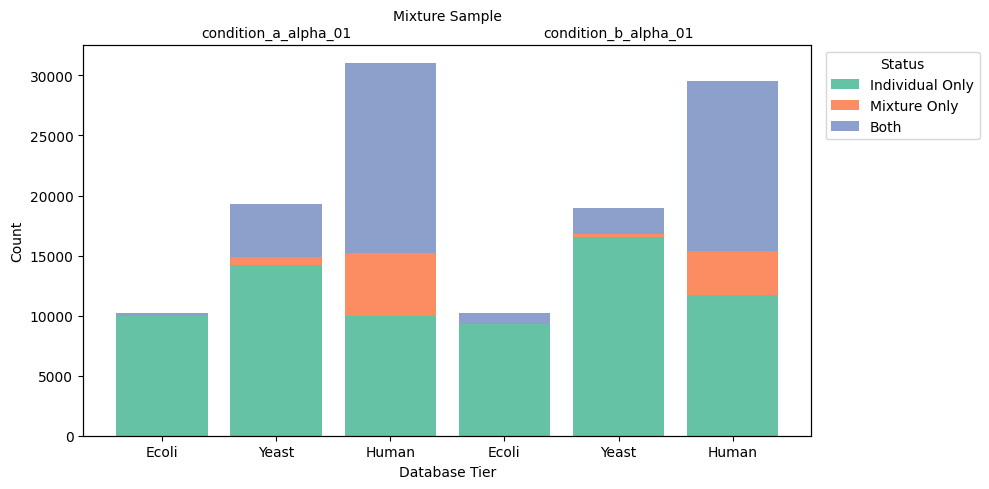

In [69]:
fig = plot_status_counts_barplot(
    comparison_table=df_sumamry,
    mixture_samples=mixture_samples
)

In [70]:
fragpipe_results['condition_a_alpha_01'].diann_report

,File.Name,Run,Protein.Group,Protein.Ids,Protein.Names,Genes,PG.Quantity,PG.Normalised,PG.MaxLFQ,Genes.Quantity,Genes.Normalised,Genes.MaxLFQ,Genes.MaxLFQ.Unique,Modified.Sequence,Stripped.Sequence,Precursor.Id,Precursor.Charge,Q.Value,PEP,Global.Q.Value,Protein.Q.Value,PG.Q.Value,Global.PG.Q.Value,GG.Q.Value,Translated.Q.Value,Proteotypic,Precursor.Quantity,Precursor.Normalised,Precursor.Translated,Translated.Quality,Ms1.Translated,Quantity.Quality,RT,RT.Start,RT.Stop,iRT,Predicted.RT,Predicted.iRT,Lib.Q.Value,Lib.PG.Q.Value,Ms1.Profile.Corr,Ms1.Area,Evidence,Spectrum.Similarity,Averagine,Mass.Evidence,CScore,Decoy.Evidence,Decoy.CScore,Fragment.Quant.Raw,Fragment.Quant.Corrected,Fragment.Correlations,MS2.Scan,IM,iIM,Predicted.IM,Predicted.iIM,All Mapped Proteins,All Mapped Genes
0,/mnt/s3bucket/data/van_puyvelde-2022/Protein/D...,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,ENSP00000267814.9,ENSP00000267814.9,NaN,ENSG00000140263.16,2336.40,2336.40,2336.40,2336.40,2336.40,2336.40,2336.40,(UniMod:1)AAAAKPNNLSLVVHGPGDLR,AAAAKPNNLSLVVHGPGDLR,(UniMod:1)AAAAKPNNLSLVVHGPGDLR3,3,4.234960e-05,1.220780e-04,4.234960e-05,0.000365,0.000332,0.000332,0.000428,0,1,1325.180,1325.180,1325.180,NaN,14735.40,0.927615,63.2955,63.0596,63.5314,48.2544,63.2955,48.2544,0,0,0.975752,14735.40,2.47760,0.553140,1.000000,2.063830,0.999888,1.499550,0.045046,4546.97;443.073;591.565;520;176.857;213.612;26...,4546.97;443.073;591.565;520;176.857;213.612;26...,0.368386;0.66726;0.971851;0.912449;0.689739;0....,68711,0,0,0,0,"ENSP00000267814.9,ENSP00000452731.1,ENSP000004...",ENSG00000140263.16
1,/mnt/s3bucket/data/van_puyvelde-2022/Protein/D...,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,ENSP00000326603.7,ENSP00000326603.7,NaN,ENSG00000101596.18,16682.80,16682.80,16682.80,16682.80,16682.80,16682.80,16682.80,(UniMod:1)AAADGGGPGGASVGTEEDGGGVGHR,AAADGGGPGGASVGTEEDGGGVGHR,(UniMod:1)AAADGGGPGGASVGTEEDGGGVGHR2,2,4.234960e-05,1.744670e-03,4.234960e-05,0.000365,0.000332,0.000332,0.000428,0,1,799.456,799.456,799.456,NaN,4066.88,0.823050,33.6024,33.3666,33.8382,24.3684,33.6024,24.3683,0,0,0.535212,4066.88,2.22213,0.732071,0.092498,1.203850,0.998408,1.425330,0.143734,334.254;139.532;21.8433;218.243;325.67;569.104...,334.254;139.532;21.8433;218.243;325.67;569.104...,0.763871;0.793551;0.461353;0.671977;0.896428;0...,36478,0,0,0,0,"ENSP00000326603.7,ENSP00000508422.1,ENSP000006...",ENSG00000101596.18
2,/mnt/s3bucket/data/van_puyvelde-2022/Protein/D...,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,ENSP00000216225.8,ENSP00000216225.8,NaN,ENSG00000100387.10,3392.79,3392.79,3392.79,3392.79,3392.79,3392.79,3392.79,(UniMod:1)AAAMDVDTPSGTNSGAGK,AAAMDVDTPSGTNSGAGK,(UniMod:1)AAAMDVDTPSGTNSGAGK2,2,4.234960e-05,2.869110e-05,4.234960e-05,0.000365,0.000332,0.000332,0.000428,0,1,1023.880,1023.880,1023.880,NaN,2313.78,0.850285,42.9096,42.6737,43.1454,31.8554,42.9094,31.8549,0,0,0.659196,2313.78,2.46920,0.623831,0.987341,1.368180,0.999974,1.429690,0.001018,276.364;245.844;558.057;219.977;252.038;92.660...,276.364;245.844;558.057;219.977;252.038;92.660...,0.689631;0.733188;0.865394;0.942824;0.695188;0...,46581,0,0,0,0,"ENSP00000216225.8,ENSP00000542201.1,ENSP000005...",ENSG00000100387.10
3,/mnt/s3bucket/data/van_puyvelde-2022/Protein/D...,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,ENSP00000216034.4,ENSP00000216034.4,NaN,ENSG00000100216.7,13928.30,13928.30,13928.30,13928.30,13928.30,13928.30,13928.30,(UniMod:1)AAAVAAAGAGEPQSPDELLPK,AAAVAAAGAGEPQSPDELLPK,(UniMod:1)AAAVAAAGAGEPQSPDELLPK2,2,4.234960e-05,2.595240e-05,4.234960e-05,0.000365,0.000332,0.000332,0.000428,0,1,4705.640,4705.640,4705.640,NaN,8660.07,0.843793,78.6421,78.4063,78.8778,60.5996,78.6426,60.5992,0,0,0.154995,8660.07,1.36546,0.811934,0.167349,1.609350,0.999976,0.947697,0.086904,2211.17;2074.27;726.106;1049.28;420.192;282.98...,2211.17;2074.27;726.106;1049.28;420.192;282.98...,0.839955;0.841348;0.724266;0.520895;0.876063;0...,85372,0,0,0,0,"ENSP00000216034.4,ENSP00000585674.1,ENSP000005...",ENSG00000100216.7
4

In [73]:
seq = fragpipe_results['condition_a_alpha_01'].split_fdr.peptide_ids[0].getHits()[0].getSequence()
seq.to

In [101]:
diann_columns = [
    'Modified.Sequence',
    'Stripped.Sequence',
    'Precursor.Charge',
    'Precursor.Quantity',
    'Precursor.Normalised'
]

df_parts = []
for s in mixture_samples:
    df_id = df_compare_peptides[df_compare_peptides['Mixture Sample'] == s]
    df_id['Peptide Name'] = df_id['Unimod Peptide'].str.lstrip('.') + '_z' + df_id['Charge'].astype(str)
    df_diann = fragpipe_results[s].diann_report[diann_columns]
    df_diann['Peptide Name'] = df_diann['Modified.Sequence'] + '_z' + df_diann['Precursor.Charge'].astype(str)
    df_merged = df_id.merge(
        right=df_diann[['Peptide Name', 'Precursor.Quantity', 'Precursor.Normalised']],
        on='Peptide Name',
        how='left'
    )
    df_parts.append(df_merged)
df_with_diann_peptides = pd.concat(df_parts)

df_parts = []
for t,s in teir_to_individual_sample.items():
    df_tier = df_with_diann_peptides[df_with_diann_peptides['Tier'] == t]
    df_diann = fragpipe_results[s].diann_report[diann_columns]
    df_diann['Peptide Name'] = df_diann['Modified.Sequence'] + '_z' + df_diann['Precursor.Charge'].astype(str)
    df_merged = df_tier.merge(
        right=df_diann[['Peptide Name', 'Precursor.Quantity', 'Precursor.Normalised']],
        on='Peptide Name',
        how='left'
    )
    df_parts.append(df_merged)
df_with_diann = pd.concat(df_parts)
del df_parts
df_with_diann

/tmp/ipykernel_8189/1143814790.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['Peptide Name'] = df_id['Unimod Peptide'].str.lstrip('.') + '_z' + df_id['Charge'].astype(str)
/tmp/ipykernel_8189/1143814790.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diann['Peptide Name'] = df_diann['Modified.Sequence'] + '_z' + df_diann['Precursor.Charge'].astype(str)
/tmp/ipykernel_8189/1143814790.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,Mixture Sample,Tier,Peptide,Modified Peptide,Unimod Peptide,Charge,Individual Sample,Mixture Present,Individual Present,Status,Peptide Name,Precursor.Quantity_x,Precursor.Normalised_x,Precursor.Quantity_y,Precursor.Normalised_y
0,condition_a_alpha_01,Ecoli,FENITAAPADPILGLADLFR,.(Acetyl)FENITAAPADPILGLADLFR,.(UniMod:1)FENITAAPADPILGLADLFR,3,ecoli_01,False,True,individual_only,(UniMod:1)FENITAAPADPILGLADLFR_z3,NaN,NaN,3812.612305,3812.612305
1,condition_a_alpha_01,Ecoli,MFENITAAPADPILGLADLFR,.(Acetyl)MFENITAAPADPILGLADLFR,.(UniMod:1)MFENITAAPADPILGLADLFR,3,ecoli_01,False,True,individual_only,(UniMod:1)MFENITAAPADPILGLADLFR_z3,NaN,NaN,2151.527344,2151.527344
2,condition_a_alpha_01,Ecoli,MIQEQTMLNVADNSGAR,.(Acetyl)MIQEQTMLNVADNSGAR,.(UniMod:1)MIQEQTMLNVADNSGAR,2,ecoli_01,False,True,individual_only,(UniMod:1)MIQEQTMLNVADNSGAR_z2,NaN,NaN,NaN,NaN
3,condition_a_alpha_01,Ecoli,MLQISHLYADYGGK,.(Acetyl)MLQISHLYADYGGK,.(UniMod:1)MLQISHLYADYGGK,2,ecoli_01,False,True,individual_only,(UniMod:1)MLQISHLYADYGGK_z2,NaN,NaN,NaN,NaN
4,condition_a_alpha_01,Ecoli,MSQPITRENFDEWMIPVYAPAPFIPVR,.(Acetyl)MSQPITRENFDEWM(Oxidation)IPVYAPAPFIPVR,.(UniMod:1)MSQPITRENFDEWM(UniMod:35)IPVYAPAPFIPVR,4,ecoli_01,False,True,individual_only,(UniMod:1)MSQPITRENFDEWM(UniMod:35)IPVYAPAPFIP...,NaN,NaN,21304.660160,21304.660160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60518,condition_b_alpha_01,Human,YYTSASGDEMVSLK,YYTSASGDEM(Oxidation)VSLK,YYTSASGDEM(UniMod:35)VSLK,2,human_01,True,True,both,YYTSASGDEM(UniMod:35)VSLK_z2,1995.41,1995.41,3289.192627,3289.192627
60519,condition_b_alpha_01,Human,YYTSASGDEMVSLK,YYTSASGDEMVSLK,YYTSASGDEMVSLK,2,human_01,True,True,both,YYTSASGDEMVSLK_z2,19849.10,19849.10,22332.597660,22332.597660
60520,condition_b_alpha_01,Human,YYVTIIDAPGHR,YYVTIIDAPGHR,YYVTIIDAPGHR,2,human_01,True,True,both,YYVTIIDAPGHR_z2,188896.00,188896.00,194598.546900,194598.546900
60521,condition_b_alpha_01,Human,YYVTIIDAPGHR,YYVTIIDAPGHR,YYVTIIDAPGHR,3,human_01,True,True,both,YYVTIIDAPGHR_z3,216867.00,216867.00,242175.218800,242175.218800


In [99]:
Counter(df_with_diann[df_with_diann['Mixture Present'] == True]['Precursor.Quantity_x'].isna())

Counter({False: 45285, True: 2298})